In [ ]:
# %%
# Notebook: GBM_Survival_Template.ipynb
# Purpose:
#   1) Read CSV
#   2) Recode variables
#   3) Derive OS / PFS / PRS
#   4) KM plots + multivariable Cox PH model

# %%
# !pip install pandas numpy matplotlib lifelines

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from config import DATA_ROOT
# Make plots look a bit nicer
plt.style.use("default")

# %%
# 1. Read CSV
# --------------------------------------------------------------------
# Set CSV path here:
csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #

df_raw = pd.read_csv(csv_path)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,04/2021,56,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,03/2025,35.3,48.2,12.9,9.2,3.7,9.2
1,2,3,"PGIMER, Chandigarh, India",SRS,08/2018,38,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,09/2024,17.9,74.4,56.5,55.8,0.7,55.8
2,3,1,Dokkyo Medical Universiry,SRS,02/2015,47,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,10/2015,4.8,8.0,3.2,2.8,0.4,2.8
3,4,7,Dokkyo Medical Universiry,SRS,02/2016,74,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,09/2017,9.5,19.6,10.2,9.0,1.1,9.0
4,5,13,Dokkyo Medical Universiry,SRS,06/2017,75,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,11/2020,25.7,40.9,15.2,14.8,0.4,14.8


In [ ]:
csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,2021-04-05,56.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,2025-03-21,35.333333,48.200000,12.866667,9.200000,3.666667,9.200000
1,2,3,"PGIMER, Chandigarh, India",SRS,2018-08-10,38.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,2024-09-18,17.900000,74.366667,56.466667,55.766667,0.700000,55.766667
2,3,1,Dokkyo Medical Universiry,SRS,2015-02-23,47.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,2015-10-22,4.800000,8.033333,3.233333,2.833333,0.400000,2.833333
3,4,7,Dokkyo Medical Universiry,SRS,2016-02-05,74.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,2017-09-16,9.466667,19.633333,10.166667,9.033333,1.133333,9.033333
4,5,13,Dokkyo Medical Universiry,SRS,2017-06-28,75.0,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,2020-11-06,25.733333,40.900000,15.166667,14.766667,0.400000,14.766667


In [84]:
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"

# read in variables
df = df_raw[time_points + variables].copy()
for col in time_points:
    # check if there is any missing data
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
# add a new column to calculate survival time
df["Survival Time (days)"] = (pd.to_datetime(df["Date of death or last follow-up"]) - pd.to_datetime(df["Date of first recurrence per RANO (date of MRI)"])).dt.days

for col in variables:
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
    # if missing, fill with median or mode
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# read a survival event column
df["Event Observed"] = df_raw["Death (1: yes / 0: no)"].astype(bool)
missing_count = df["Event Observed"].isnull().sum()
print(f"Missing values in 'Event Observed': {missing_count}")

# survival time prediction
df = df[df["Survival Time (days)"] >= 0]  # remove negative survival times
print("Processed shape:", df.shape)

# use survivaltree to predict survival


df.head()



Missing values in 'Date of first recurrence per RANO (date of MRI)': 0
Missing values in 'Date of death or last follow-up': 0
Missing values in 'Age at diagnosis': 0
Missing values in 'KPS before SRS or re-RT for Recurrence': 5
Missing values in 'Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)': 16
Missing values in 'SRS Dose (Gy)': 1
Missing values in 'Event Observed': 0
Processed shape: (272, 8)


/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_30027/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_30027/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,Date of first recurrence per RANO (date of MRI),Date of death or last follow-up,Age at diagnosis,KPS before SRS or re-RT for Recurrence,Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),SRS Dose (Gy),Survival Time (days),Event Observed
0,2024-02-29,2025-03-21,56.0,80.0,3.000,16.0,386,False
1,2020-01-29,2024-09-18,38.0,90.0,1.020,10.0,1694,False
2,2015-07-17,2015-10-22,47.0,80.0,4.626,20.0,97,True
3,2016-11-15,2017-09-16,74.0,80.0,1.509,20.0,305,True
4,2019-08-09,2020-11-06,75.0,90.0,2.414,20.0,455,False


In [85]:
from sksurv.util import Surv
from sksurv.tree import SurvivalTree
from sksurv.metrics import concordance_index_censored

#
# Prepare data for survival tree
y_structured = Surv.from_dataframe("Event Observed", "Survival Time (days)", df)
X = df[variables]
# Fit survival tree
surv_tree = SurvivalTree(max_depth=2, min_samples_split=6)
surv_tree.fit(X, y_structured)
# Predict risk scores
risk_scores = -surv_tree.predict(X)  # negative because higher risk should correspond to lower survival
# Evaluate concordance index
c_index = concordance_index_censored(df["Event Observed"], df["Survival Time (days)"], risk_scores)
print("Concordance Index:", c_index[0]) 




Concordance Index: 0.3936749739039666


In [ ]:
# model: fitted SurvivalTree() or RandomSurvivalForest()
# x0: a single-row DataFrame with columns like ["dose", "age", "gender", ...]
# t_star: time horizon (same unit as your y["time"], e.g., days)
# doses: candidate dose grid
 
def best_dose_by_survival_at_t(model, x0: pd.DataFrame, doses, t_star: float):
    Xcand = pd.concat([x0]*len(doses), ignore_index=True)
    Xcand["SRS Dose (Gy)"] = doses
 
    surv_funcs = model.predict_survival_function(Xcand)
 
    # Evaluate S(t_star) for each candidate
    S = np.array([sf(t_star) for sf in surv_funcs])
 
    i_best = int(np.argmax(S))
    return doses[i_best], S[i_best], S

# Example dose grid (choose clinically valid bounds/step)
doses = np.linspace(0, 70, 141)  # 0..70 Gy in 0.5 Gy steps

for idx, x0 in X.iterrows():
    t_star = df.iloc[idx]["Survival Time (days)"]
    d_best, S_best, S_all = best_dose_by_survival_at_t(surv_tree, x0.to_frame().T, doses, t_star=t_star)
    print(d_best, S_best)





0.0 0.5650185436328165
0.0 0.11494282247080953
0.0 0.9463945578231292
0.0 0.6957305141134357
0.0 0.49173360745004424
0.0 0.7970664087685365
0.0 0.25191563755393565
0.0 0.5693331491203836
0.0 0.871472548232532
0.0 0.508124727698379
0.0 0.43276285874079196
0.0 0.8438014398576944
0.0 0.8577485710950118
0.0 0.7805163318683674
0.0 0.549102528319216
0.0 0.45839573575851583
0.0 0.16420403210115647
0.0 0.16420403210115647
0.0 0.24312453567319867
0.0 0.5650185436328165
0.0 0.7594212958719252
0.0 0.30046839167336004
0.0 0.16420403210115647
0.0 0.8438014398576944
0.0 0.8507750054763531
0.0 0.34599390556326304
0.0 0.8016113678648098
0.0 0.11904761904761907
0.0 0.9125405101213234
0.0 0.08397187918464523
0.0 0.21273396871404887
0.0 0.5245158479467138
0.0 0.4067970872163444
0.0 0.2380952380952381
0.0 0.9665306122448978
0.0 0.6245744024189817
0.0 0.6673333502720709
0.0 0.9787234042553191
0.0 0.7383262598754827
0.0 0.8577485710950118
0.0 0.8989205025075723
0.0 0.6376531270148295
0.0 0.40357420357420365

In [ ]:
# %%
# 2. Recode / rename key variables
# --------------------------------------------------------------------
# Column names on the LEFT must match CSV headers EXACTLY.
# Names on the RIGHT are analysis-friendly names.

column_map = {
    "Date of first diagnosis (date of first surgery)": "diag_date",
    "Age at diagnosis": "age_dx",
    "Sex (M/F)": "sex",
    "MGMT (methyl/unmethyl/n.a.)": "mgmt_raw",
    "1st Recurrence (1: yes, 0: no)": "rec1_flag",
    "Date of first recurrence per RANO (date of MRI)": "rec1_date",
    "Date of SRS or last day of re-RT for recurrence": "srs_date",
    "KPS before SRS or re-RT for Recurrence": "kps_srs",
    "Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)": "vol_srs",
    "SRS Dose (Gy)": "srs_dose",
    "Surgical Resection (1: yes, 0: no)": "rec1_surg",
    "Deep-seated tumor": "deep_tumor_rec",  # adjust if name slightly different
    "Death (1: yes / 0: no)": "death",
    "Date of death or last follow-up": "last_fu_date"
}

# Keep original for reference; create a working copy
df = df_raw.rename(columns=column_map).copy()

# Check that critical columns exist
required_cols = ["diag_date", "age_dx", "sex", "mgmt_raw",
                 "rec1_flag", "rec1_date", "srs_date", "kps_srs",
                 "vol_srs", "srs_dose", "rec1_surg",
                 "death", "last_fu_date"]

missing = [c for c in required_cols if c not in df.columns]
print("Missing required columns:", missing)


Missing required columns: []


In [ ]:
# %%
# 3. Convert date columns to datetime
# --------------------------------------------------------------------
date_cols = ["diag_date", "rec1_date", "srs_date", "last_fu_date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# Basic cleaning for numeric vars
numeric_cols = ["age_dx", "kps_srs", "vol_srs", "srs_dose",
                "rec1_flag", "rec1_surg", "death"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# %%
# 3.1 Derive Overall Survival (OS)
# --------------------------------------------------------------------
# OS time: from diag_date to death or last_fu_date.
# OS event: death == 1

def to_months(delta):
    return delta.days / 30.44

df["os_event"] = df["death"]
df["os_time_months"] = np.nan

mask_os = df["diag_date"].notna() & df["last_fu_date"].notna()
df.loc[mask_os, "os_time_months"] = (df.loc[mask_os, "last_fu_date"] -
                                     df.loc[mask_os, "diag_date"]).apply(to_months)

print("OS time summary (months):")
print(df["os_time_months"].describe())

# %%
# 3.2 Derive Progression-Free Survival (PFS)
# --------------------------------------------------------------------
# Simple definition:
#   PFS time = from diag_date to earliest of (recurrence, death, last_fu)
#   PFS event = 1 if recurrence OR death happened; 0 if censored

df["pfs_time_months"] = np.nan
df["pfs_event"] = 0

# Only consider rows with diag_date and last_fu_date
mask_base = df["diag_date"].notna() & df["last_fu_date"].notna()

for idx, row in df[mask_base].iterrows():
    t0 = row["diag_date"]
    t_last = row["last_fu_date"]
    t_rec = row["rec1_date"]
    died = row["death"] == 1
    rec = row.get("rec1_flag", 0) == 1

    # candidate event dates
    dates = []
    if pd.notna(t_rec) and rec:
        dates.append(t_rec)
    if died:
        dates.append(t_last)  # death date assumed == last_fu_date if death=1

    if dates:
        t_event = min(dates)
        df.loc[idx, "pfs_time_months"] = to_months(t_event - t0)
        df.loc[idx, "pfs_event"] = 1
    else:
        df.loc[idx, "pfs_time_months"] = to_months(t_last - t0)
        df.loc[idx, "pfs_event"] = 0

print("PFS time summary (months):")
print(df["pfs_time_months"].describe())

# %%
# 3.3 Derive Post-Recurrence Survival (PRS) from 1st recurrence
# --------------------------------------------------------------------
# PRS time = from rec1_date to death or last_fu
# PRS event = death == 1
# Only defined for patients with recorded recurrence date

df["prs_time_months"] = np.nan
df["prs_event"] = np.nan

mask_prs = df["rec1_date"].notna() & df["last_fu_date"].notna()
df.loc[mask_prs, "prs_event"] = df.loc[mask_prs, "death"]

df.loc[mask_prs, "prs_time_months"] = (
    df.loc[mask_prs, "last_fu_date"] - df.loc[mask_prs, "rec1_date"]
).apply(to_months)

print("PRS time summary (months):")
print(df["prs_time_months"].describe())


OS time summary (months):
count    272.000000
mean      29.525175
std       20.077050
min        5.913272
25%       17.271682
50%       22.207622
75%       34.789750
max      134.986859
Name: os_time_months, dtype: float64
PFS time summary (months):
count    272.000000
mean      14.433891
std       14.087776
min        0.000000
25%        5.839356
50%       10.118265
75%       17.320959
max      122.470434
Name: pfs_time_months, dtype: float64
PRS time summary (months):
count    272.000000
mean      15.091284
std       14.547314
min        0.000000
25%        6.898817
50%       11.185940
75%       16.606439
max       91.425756
Name: prs_time_months, dtype: float64


In [ ]:
# %%
# 4. Recode key predictors
# --------------------------------------------------------------------
# 4.1 MGMT: methylated vs unmethylated
def recode_mgmt(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if "methyl" in s and "un" not in s:
        return "methylated"
    if "unmethyl" in s or "un-methyl" in s:
        return "unmethylated"
    return np.nan

df["mgmt"] = df["mgmt_raw"].apply(recode_mgmt)

# Binary version: 1 = methylated, 0 = unmethylated
df["mgmt_meth"] = np.where(df["mgmt"] == "methylated", 1,
                           np.where(df["mgmt"] == "unmethylated", 0, np.nan))

# 4.2 Sex: M/F
df["sex"] = df["sex"].astype(str).str.strip().str.upper()
df["sex_male"] = np.where(df["sex"] == "M", 1,
                          np.where(df["sex"] == "F", 0, np.nan))

# 4.3 SRS dose group: example cutoff at 16 Gy (you can adjust)
dose_cut = 16.0

df["srs_dose_high"] = np.where(df["srs_dose"] > dose_cut, 1,
                               np.where(df["srs_dose"].isna(), np.nan, 0))

# 4.4 Volume: log-transform for modeling
df["vol_srs_log"] = np.log1p(df["vol_srs"])  # log(1 + volume)

# Check
df[["mgmt_raw", "mgmt", "mgmt_meth", "sex", "sex_male", "srs_dose", "srs_dose_high", "vol_srs", "vol_srs_log"]].head()


,mgmt_raw,mgmt,mgmt_meth,sex,sex_male,srs_dose,srs_dose_high,vol_srs,vol_srs_log
0,NaN,NaN,NaN,F,0.0,NaN,NaN,3.000,1.386294
1,NaN,NaN,NaN,M,1.0,10.0,0.0,1.020,0.703098
2,NaN,NaN,NaN,F,0.0,20.0,1.0,4.626,1.727399
3,NaN,NaN,NaN,M,1.0,20.0,1.0,1.509,0.919884
4,NaN,NaN,NaN,M,1.0,20.0,1.0,2.414,1.227885


In [ ]:
# %%
# 4b. Extra recodes for the base Cox model you specified
# --------------------------------------------------------------------
# Add to earlier renaming step, or run separately

column_map_extra = {
    "Type of surgery (biopsy/craniotomy)": "surg_type_initial",
    "Recurrence  localization (1: cortical (sub-cortical) / 2: deep-seated (basal ganglia/thalamus) or midline / 3: multifocal)": "rec_pattern",
    "Deep-seated tumor": "deep_tumor_rec"   # adjust if recurrence-version column name is slightly different
}

df = df.rename(columns=column_map_extra)

# 4b.1 Extent of initial resection (biopsy vs craniotomy)
# -------------------------------------------------------
# We’ll create:
#   - surg_resection_initial: 1 = craniotomy (resection), 0 = biopsy
# You could also keep the original string var for descriptive tables.

def recode_surg_type(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if "craniot" in s or "resect" in s:
        return 1   # resection
    if "biopsy" in s:
        return 0   # biopsy-only
    return np.nan

df["surg_resection_initial"] = df["surg_type_initial"].apply(recode_surg_type)

# 4b.2 Recurrence pattern (cortical vs deep vs multifocal)
# --------------------------------------------------------
# Original meaning:
#   rec_pattern = 1: cortical/subcortical
#                 2: deep-seated
#                 3: multifocal
#
# For the base Cox we want:
#   - recurrence pattern categorical (with 1 as reference)
#   - deep vs superficial as a binary variable

df["rec_pattern_num"] = pd.to_numeric(df["rec_pattern"], errors="coerce")

# Categorical version (for one-hot encoding later if needed)
df["rec_pattern_cat"] = df["rec_pattern_num"].astype("Int64")  # 1/2/3

# Deep vs superficial (cortical/subcortical = 0, deep/midline = 1)
df["deep_vs_superficial"] = np.where(df["rec_pattern_num"] == 2, 1,
                                     np.where(df["rec_pattern_num"].isin([1, 3]), 0, np.nan))

# 4b.3 Deep vs superficial location (already partially covered)
# -------------------------------------------------------------
# If "deep_tumor_rec" is already a binary 1/0, we can keep it.
df["deep_tumor_rec"] = pd.to_numeric(df["deep_tumor_rec"], errors="coerce")

# Quick sanity check of all recoded covariates
df[["surg_type_initial", "surg_resection_initial",
    "rec_pattern", "rec_pattern_num", "rec_pattern_cat",
    "deep_vs_superficial", "deep_tumor_rec"]].head()


,surg_type_initial,surg_resection_initial,rec_pattern,rec_pattern_num,rec_pattern_cat,deep_vs_superficial,deep_tumor_rec
0,Craniotomy,1,1,1.0,1,0.0,NaN
1,Craniotomy,1,1,1.0,1,0.0,NaN
2,Craniotomy,1,1,1.0,1,0.0,NaN
3,Craniotomy,1,3,3.0,3,0.0,NaN
4,Craniotomy,1,1,1.0,1,0.0,NaN


In [ ]:
# %%
# 5.4 Helper: generic KM plot stratified by a grouping variable
# --------------------------------------------------------------------

def plot_km_by_group(df,
                     time_col: str,
                     event_col: str,
                     group_col: str,
                     group_labels: dict = None,
                     title: str = "",
                     min_group_size: int = 5):
    """
    Plot Kaplan–Meier curves for OS stratified by a group variable.

    Parameters
    ----------
    df : DataFrame
        Data with time, event, and group columns.
    time_col : str
        Column name for survival time.
    event_col : str
        Column name for event indicator (1=event, 0=censored).
    group_col : str
        Column name for grouping variable (numeric or categorical).
    group_labels : dict, optional
        Mapping from group value -> label for legend.
    title : str
        Plot title.
    min_group_size : int
        Minimum number of patients per group to be plotted.
    """
    data = df[[time_col, event_col, group_col]].dropna().copy()
    if data.empty:
        print(f"No data for {group_col}.")
        return
    
    # Convert to category for safety
    data[group_col] = data[group_col].astype("category")
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots()

    for g in data[group_col].cat.categories:
        mask = data[group_col] == g
        n = mask.sum()
        if n < min_group_size:
            continue  # skip tiny groups
        
        label = group_labels.get(g, str(g)) if group_labels else str(g)
        kmf.fit(data.loc[mask, time_col],
                event_observed=data.loc[mask, event_col],
                label=f"{label} (n={n})")
        kmf.plot(ax=ax)
    
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Survival probability")
    ax.set_title(title or f"{time_col} by {group_col}")
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# %%
# 5.5 Create categorical groups for age, KPS, and volume
# --------------------------------------------------------------------
# Age groups
df["age_group"] = pd.cut(
    df["age_dx"],
    bins=[0, 60, 70, np.inf],
    labels=["<60", "60–69", "≥70"],
    right=False
)

# KPS groups (typical clinical cutpoints)
df["kps_group"] = pd.cut(
    df["kps_srs"],
    bins=[0, 70, 90, 101],
    labels=["<70", "70–80", "90–100"],
    right=False
)

# Tumor volume group at SRS (example cutoff 3 cm³)
# vol_cut = 3.0
# df["vol_group"] = np.where(df["vol_srs"] <= vol_cut, 0,
#                            np.where(df["vol_srs"] > vol_cut, 1, np.nan))
vol_cut = 3.0
df["vol_group"] = pd.cut(
    df["vol_srs"],
    bins=[0, vol_cut, np.inf],
    labels=[f"≤{vol_cut} cm³", f">{vol_cut} cm³"],
    include_lowest=True
)

# Recurrence pattern: 1=cortical, 2=deep, 3=multifocal
rec_pattern_labels = {
    1: "Cortical/subcortical",
    2: "Deep-seated",
    3: "Multifocal"
}

# SRS dose group labels (we already defined srs_dose_high using 16 Gy)
dose_cut = 16.0  # keep consistent with previous cells
# df["srs_dose_group"] = np.where(df["srs_dose_high"] == 1,
#                                 f"> {dose_cut} Gy",
#                                 np.where(df["srs_dose_high"] == 0,
#                                          f"≤ {dose_cut} Gy",
#                                          np.nan))
df["srs_dose_group"] = df["srs_dose_high"].map({
    1: f"> {dose_cut} Gy",
    0: f"≤ {dose_cut} Gy"
})


# Deep vs superficial (based on rec_pattern_num)
#  deep_vs_superficial: 1=deep, 0=superficial/multifocal
deep_sup_labels = {
    0: "Superficial/multifocal",
    1: "Deep-seated"
}


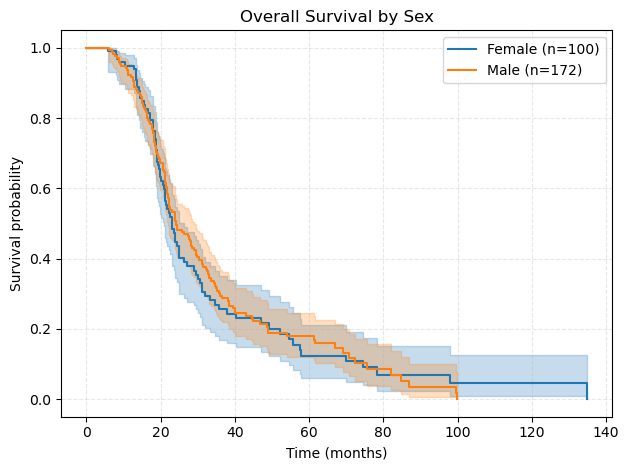

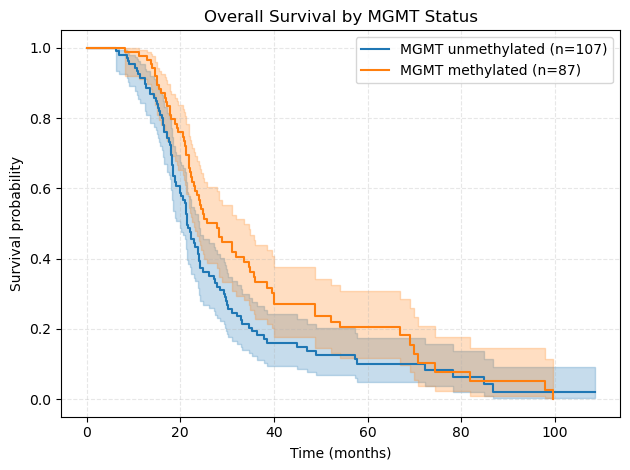

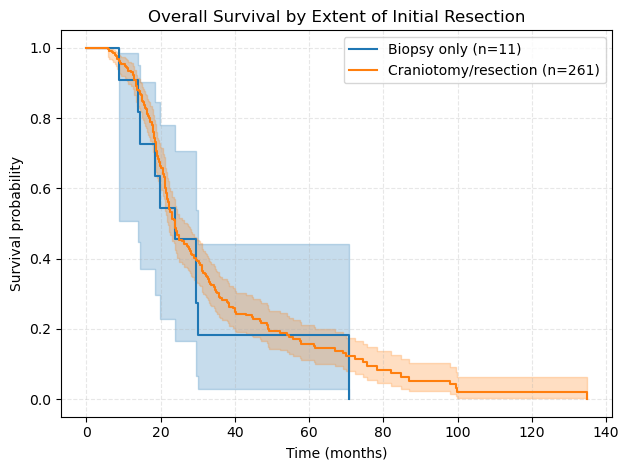

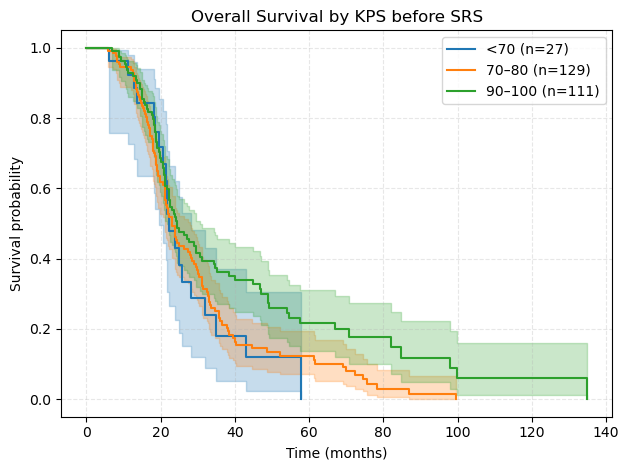

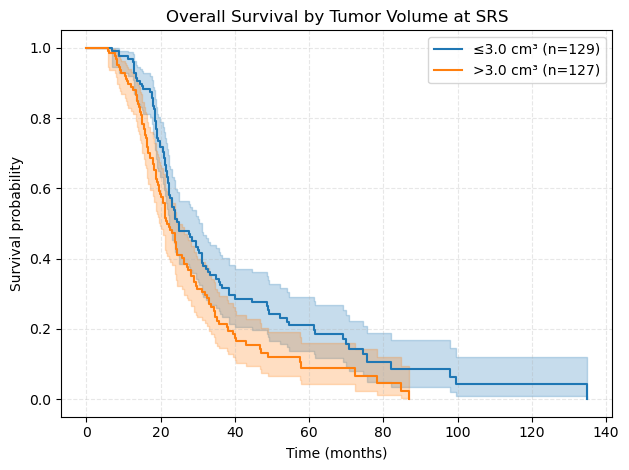

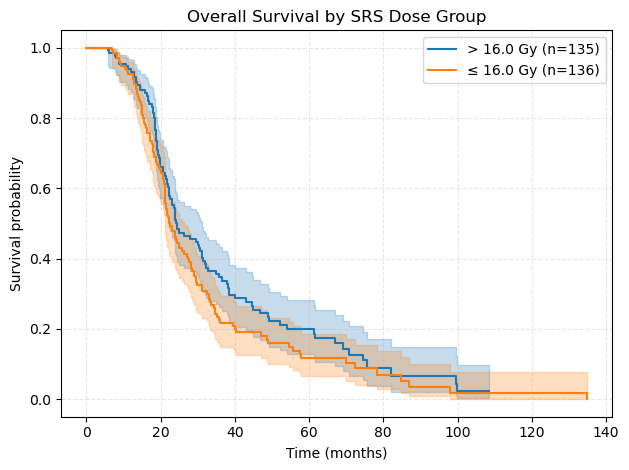

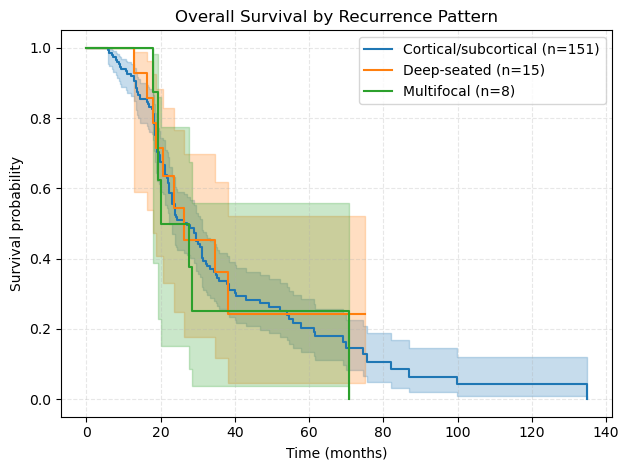

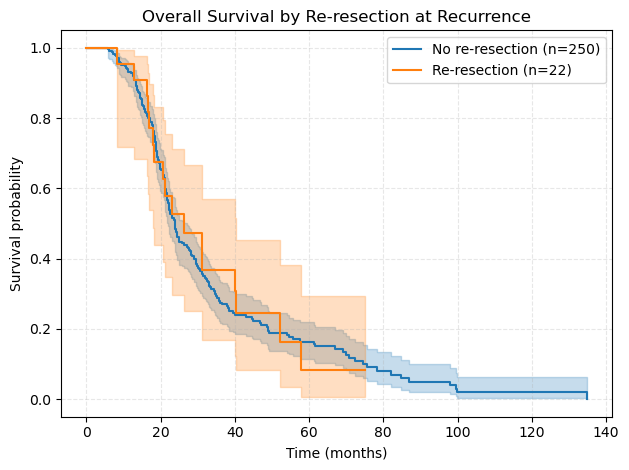

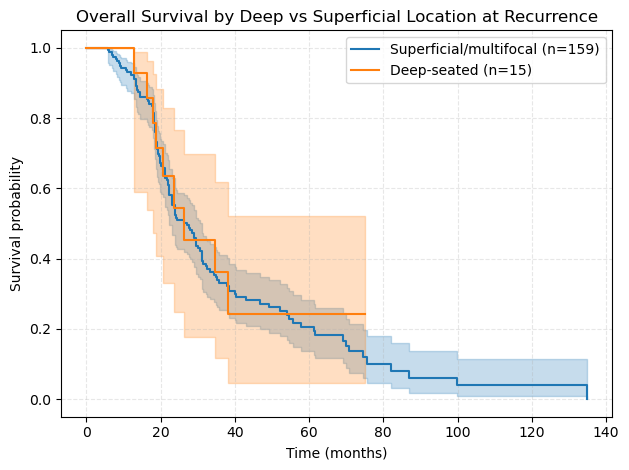

In [ ]:
# %%
# 5.6 OS stratified by SEX
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="sex_male",
    group_labels={0: "Female", 1: "Male"},
    title="Overall Survival by Sex"
)

# %%
# 5.7 OS stratified by MGMT methylation
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="mgmt_meth",
    group_labels={0: "MGMT unmethylated", 1: "MGMT methylated"},
    title="Overall Survival by MGMT Status"
)

# %%
# 5.8 OS stratified by extent of initial resection (biopsy vs craniotomy)
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="surg_resection_initial",
    group_labels={0: "Biopsy only", 1: "Craniotomy/resection"},
    title="Overall Survival by Extent of Initial Resection"
)

# %%
# 5.9 OS stratified by KPS group before SRS
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="kps_group",
    group_labels=None,
    title="Overall Survival by KPS before SRS"
)

# %%
# 5.10 OS stratified by tumor volume group at SRS
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="vol_group",
    title="Overall Survival by Tumor Volume at SRS"
)

# %%
# 5.11 OS stratified by SRS dose group (<= 16 vs > 16 Gy)
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="srs_dose_group",
    title="Overall Survival by SRS Dose Group"
)

# %%
# 5.12 OS stratified by recurrence pattern (cortical, deep, multifocal)
# --------------------------------------------------------------------
plot_km_by_group(
    df=df.assign(rec_pattern_num=df["rec_pattern_num"].astype("Int64")),
    time_col="os_time_months",
    event_col="os_event",
    group_col="rec_pattern_num",
    group_labels=rec_pattern_labels,
    title="Overall Survival by Recurrence Pattern"
)

# %%
# 5.13 OS stratified by re-resection at recurrence
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="rec1_surg",
    group_labels={0: "No re-resection", 1: "Re-resection"},
    title="Overall Survival by Re-resection at Recurrence"
)

# %%
# 5.14 OS stratified by deep vs superficial location at recurrence
# --------------------------------------------------------------------
plot_km_by_group(
    df=df,
    time_col="os_time_months",
    event_col="os_event",
    group_col="deep_vs_superficial",
    group_labels=deep_sup_labels,
    title="Overall Survival by Deep vs Superficial Location at Recurrence"
)


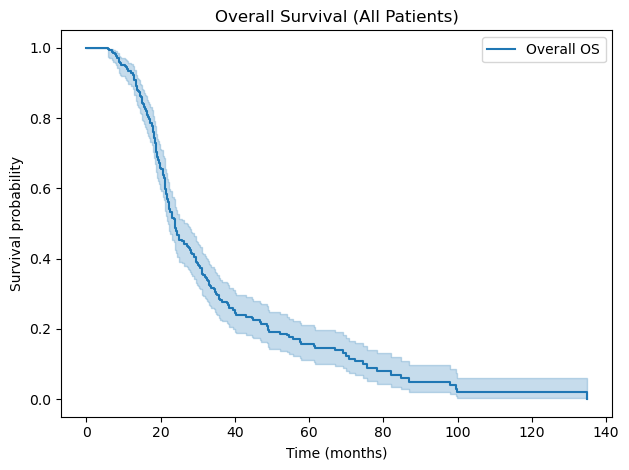

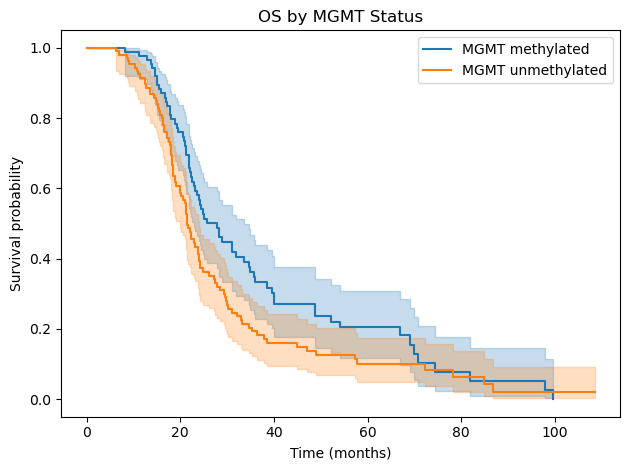

Log-rank test MGMT methylated vs unmethylated:
   test_statistic         p  -log2(p)
0          4.8807  0.027159  5.202447


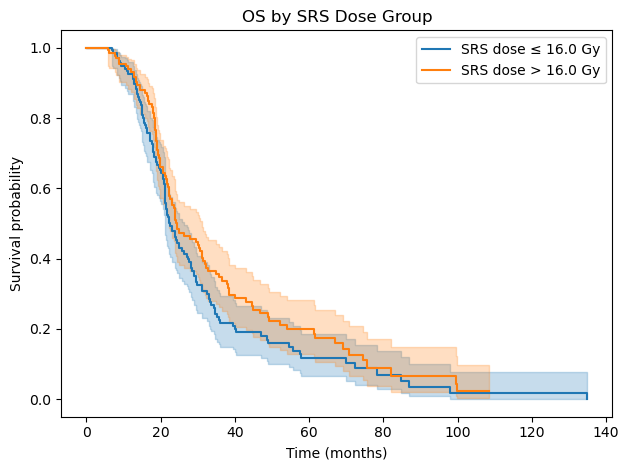

Log-rank test SRS high vs low dose:
   test_statistic         p  -log2(p)
0        2.439186  0.118338  3.079019


In [ ]:
# %%
# 5. Kaplan–Meier curves for OS
# --------------------------------------------------------------------
kmf = KaplanMeierFitter()

# 5.1 Overall OS
mask_km = df["os_time_months"].notna() & df["os_event"].notna()
kmf.fit(df.loc[mask_km, "os_time_months"],
        event_observed=df.loc[mask_km, "os_event"],
        label="Overall OS")

ax = kmf.plot()
ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")
ax.set_title("Overall Survival (All Patients)")
plt.tight_layout()
plt.show()

# %%
# 5.2 OS stratified by MGMT methylation
# --------------------------------------------------------------------
mask_mgmt = mask_km & df["mgmt"].notna()

groups = df.loc[mask_mgmt, "mgmt"]
ix_meth = groups == "methylated"
ix_unmeth = groups == "unmethylated"

kmf_meth = KaplanMeierFitter()
kmf_unmeth = KaplanMeierFitter()

fig, ax = plt.subplots()

kmf_meth.fit(df.loc[mask_mgmt & ix_meth, "os_time_months"],
             event_observed=df.loc[mask_mgmt & ix_meth, "os_event"],
             label="MGMT methylated").plot(ax=ax)

kmf_unmeth.fit(df.loc[mask_mgmt & ix_unmeth, "os_time_months"],
               event_observed=df.loc[mask_mgmt & ix_unmeth, "os_event"],
               label="MGMT unmethylated").plot(ax=ax)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")
ax.set_title("OS by MGMT Status")
plt.tight_layout()
plt.show()

# Log-rank test
if ix_meth.sum() > 0 and ix_unmeth.sum() > 0:
    res_lr = logrank_test(
        df.loc[mask_mgmt & ix_meth, "os_time_months"],
        df.loc[mask_mgmt & ix_unmeth, "os_time_months"],
        event_observed_A=df.loc[mask_mgmt & ix_meth, "os_event"],
        event_observed_B=df.loc[mask_mgmt & ix_unmeth, "os_event"]
    )
    print("Log-rank test MGMT methylated vs unmethylated:")
    print(res_lr.summary)

# %%
# 5.3 OS stratified by SRS dose group (<= 16 vs > 16 Gy)
# --------------------------------------------------------------------
mask_dose = mask_km & df["srs_dose_high"].notna()

ix_high = df["srs_dose_high"] == 1
ix_low = df["srs_dose_high"] == 0

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

fig, ax = plt.subplots()

kmf_low.fit(df.loc[mask_dose & ix_low, "os_time_months"],
            event_observed=df.loc[mask_dose & ix_low, "os_event"],
            label=f"SRS dose ≤ {dose_cut} Gy").plot(ax=ax)

kmf_high.fit(df.loc[mask_dose & ix_high, "os_time_months"],
             event_observed=df.loc[mask_dose & ix_high, "os_event"],
             label=f"SRS dose > {dose_cut} Gy").plot(ax=ax)

ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")
ax.set_title("OS by SRS Dose Group")
plt.tight_layout()
plt.show()

# 

# Log-rank test
if ix_high.sum() > 0 and ix_low.sum() > 0:
    res_lr_dose = logrank_test(
        df.loc[mask_dose & ix_high, "os_time_months"],
        df.loc[mask_dose & ix_low, "os_time_months"],
        event_observed_A=df.loc[mask_dose & ix_high, "os_event"],
        event_observed_B=df.loc[mask_dose & ix_low, "os_event"]
    )
    print("Log-rank test SRS high vs low dose:")
    print(res_lr_dose.summary)


start with a simple model, can expand the variables later. 
Currently, variables includes:
age
sex
MGMT methylation
KPS at SRS
log volume
SRS dose group
re-resection at recurrence
deep-tumor-at-recurrence

In [ ]:
# %%
# 6. Multivariable Cox PH model for OS
# --------------------------------------------------------------------
cox_vars = [
    "os_time_months",
    "os_event",
    "age_dx",
    "sex_male",
    "mgmt_meth",
    "kps_srs",
    "vol_srs_log",
    "srs_dose_high",
    "rec1_surg",
    "deep_tumor_rec"
]

# subset & drop rows with missing in any of these vars
df_cox = df[cox_vars].dropna().copy()
print("Cox model sample size:", df_cox.shape[0])

# Lifelines CoxPHFitter expects a dataframe with:
#  - duration column name
#  - event column name
#  - plus covariates

cph = CoxPHFitter()
cph.fit(df_cox,
        duration_col="os_time_months",
        event_col="os_event")

cph.print_summary()  # HRs, 95% CI, p-values

# %%
# 6.1 Check proportional hazards assumption (quick check)
# --------------------------------------------------------------------
# Note: This can be time-consuming for large models.
cph.check_assumptions(df_cox, p_value_threshold=0.05)


Cox model sample size: 0


ZeroDivisionError: division by zero